In [213]:
import numpy as np
import matplotlib.pyplot as plt


In [214]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

In [215]:

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

In [216]:
def sigmoid(z):
    return 1/(1+np.exp(-z))
    

In [217]:
def relu(z):
    return np.maximum(0,z)

In [218]:
def get_cost(AL, Y):
    m = Y.shape[1]
    cost = np.multiply(np.log(AL),Y) + np.multiply(np.log(1 - AL),(1 - Y))
    cost = -1 * (1/m) * np.sum(cost)
    cost = np.squeeze(cost)  
    return cost

In [219]:
def cost_deriv(AL, Y):
    return - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

In [220]:
def sigmoid_deriv(dA, cache):
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [221]:
def relu_deriv(dA, cache):    
    Z = cache
    dZ = np.array(dA, copy=True) 
 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [222]:
X, Y = load_planar_dataset()

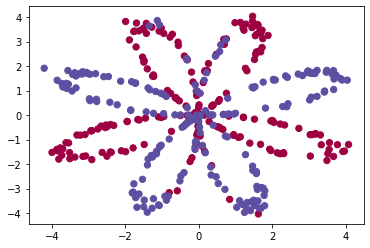

In [223]:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

In [295]:
class NeuralNet():
    def __init__(self, layers):
        self.params = {} # network parameters
        self.grads = {}  #network gradients
        self.n_x = 0     # input layer hidden units
        self.layers_count = len(layers)
        self.layers_units = layers
        
        
        
        
        
    def forward_prop(self, X, y):
        Z_list = [0]
        A_prev = X
        A_list = [A_prev]
        for l in range(1, self.layers_count):
            W = self.params['W'+ str(l)]
            b = self.params['b'+ str(l)]
            Z = np.dot(W, A_prev) + b
            Z_list.append(Z)
            
            A = sigmoid(Z) if l == (self.layers_count - 1) else relu(Z)
            A_list.append(A)
            A_prev = A
        cost = get_cost(A, y)
        print('cost: ',cost)
        return {"AL": A, "Zs":Z_list, "As": A_list}
        
        
        
        
        
    def back_prop(self, Y, cache):
        m = Y.shape[1]
        dA = cost_deriv(cache["AL"], Y)
        for l in reversed(range(1, self.layers_count)):
            AL_1 = cache["As"][l - 1]
            dZl = sigmoid_deriv(dA, cache["Zs"][l]) if (l==self.layers_count - 1) else relu_deriv(dA, cache["Zs"][l])
            dW = (1/m) * np.dot(dZl, AL_1.T)
            db = (1/m) * np.sum(dZl, axis=1, keepdims=True)
            W = self.params['W'+str(l)]
            dA = np.dot(W.T, dZl)
            self.grads['dW'+str(l)] = dW
            self.grads['db'+str(l)] = db
            
            
      
    
    
    
    
    
    
    
        
    def update_params(self, lr):
        for l in range(1, self.layers_count):
            self.params['W'+str(l)] = self.params['W'+str(l)] - lr*self.grads['dW'+str(l)]
            self.params['b'+str(l)] = self.params['b'+str(l)] - lr*self.grads['db'+str(l)]
        
        
        
    
    def add_input_units(self, X):
        self.layers_units.insert(0, X.shape[0])
        self.layers_count += 1
        print(self.layers_units)    
    
    def init_weights(self):
        for l in range(1, self.layers_count):
            self.params['W'+ str(l)] = np.random.randn(self.layers_units[l], self.layers_units[l-1])     
            self.params['b'+ str(l)] = np.zeros((self.layers_units[l], 1))     
        for par in self.params:
            print(par, " : ",self.params[par].shape)
        
        
    def fit(self, X, Y, learning_rate, epochs):
        self.add_input_units(X)
        self.init_weights()
        
        # training the model
        for e in range(epochs):
            forward_cache = self.forward_prop(X, Y)
            self.back_prop(Y, forward_cache)
            self.update_params(learning_rate)
            
            
    def predict(self, X):
        A_prev = X
        for l in range(1, self.layers_count):
            W = self.params['W'+ str(l)]
            b = self.params['b'+ str(l)]
            Z = np.dot(W, A_prev) + b
            A = sigmoid(Z) if l == (self.layers_count - 1) else relu(Z)
            A_prev = A
        return (A>=0.5)
        
     
        

In [349]:
print(X.shape)
layers_dims = [4, 20, 10, 4, 2, 1]
nn = NeuralNet(layers_dims)
print(Y)
nn.fit(X, Y, 0.05, 1000)

(2, 400)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1]]
[2, 4, 20, 10, 4, 2, 1]
W1  :  (4, 2)
b1  :  (4, 1)
W2  :  (20, 4)
b2  :  (20, 1)
W3  :  (10, 20)
b3  :  (10, 1)
W4  :  (4, 10)
b4  :  (4, 1)
W5  :  (2, 4)
b5  :  (2

cost:  0.5104549872430962
cost:  0.5102118539428004
cost:  0.5100005143031583
cost:  0.5097906020942611
cost:  0.5095814284029172
cost:  0.5094008223682476
cost:  0.5092127211533515
cost:  0.5090027023968792
cost:  0.5088373512001785
cost:  0.5086358453775662
cost:  0.508485700666807
cost:  0.5083050800726328
cost:  0.5081539183558968
cost:  0.5080161592758128
cost:  0.5078595704803139
cost:  0.5076370261115413
cost:  0.5074213077468231
cost:  0.507759605070196
cost:  0.5064464976729743
cost:  0.5060591731250389
cost:  0.5057071682559946
cost:  0.5056622194126928
cost:  0.5058042596944308
cost:  0.5063497096508391
cost:  0.5062336059893113
cost:  0.5050862133811195
cost:  0.5041565242573824
cost:  0.504015987048015
cost:  0.503556882767821
cost:  0.503100927065703
cost:  0.502751101693525
cost:  0.504857506376607
cost:  0.5178661888431434
cost:  0.5540817212548044
cost:  0.8120912457770589
cost:  0.6978312890004793
cost:  0.641424338739025
cost:  0.5601981214703868
cost:  0.52290130599

cost:  0.4811601201673969
cost:  0.4811008242886742
cost:  0.48104498776224386
cost:  0.48093663140287946
cost:  0.4808879691408846
cost:  0.48084060194537004
cost:  0.4807039405577859
cost:  0.48067624778802936
cost:  0.4806082115409446
cost:  0.48056230870339334
cost:  0.48046107250118264
cost:  0.4803972897605132
cost:  0.48037736480477206
cost:  0.48032324201909327
cost:  0.4802005101699294
cost:  0.4801442761619218
cost:  0.4801239489689483
cost:  0.4800283798057933
cost:  0.4799758068498301
cost:  0.47992635401753875
cost:  0.4798294943073147
cost:  0.4798121403742611
cost:  0.47973000513060804
cost:  0.4796388036864242
cost:  0.4796323109828049
cost:  0.4795574071156439
cost:  0.47946614142311517
cost:  0.4794529175585763
cost:  0.47934986414588454
cost:  0.47934419100179043
cost:  0.47925178416981246
cost:  0.479158156599082
cost:  0.4791496978244388
cost:  0.47906036592070506
cost:  0.47902826327175746
cost:  0.4789459019182978
cost:  0.4789454849470376
cost:  0.47885496408053

In [350]:
preds = nn.predict(X)
preds

array([[False,  True,  True,  True, False,  True, False, False, False,
        False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
      

In [351]:
preds_bin = np.where(preds == True, 1, preds)
p_array = preds_bin[0]
g_truth = Y[0]
total = len(g_truth)
false = 0
true = 0
for i in range(len(p_array)):
    if (p_array[i] == g_truth[i]):
        true += 1
    else:
        false += 1

        
print("accuracy: ", (true/total)*100, "%")

accuracy:  78.25 %
